In [151]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, collections
from scipy.stats import norm
import imp, os, pickle
import warnings
import sys
from matplotlib import collections  as mc
from scipy.stats import poisson
warnings.filterwarnings("ignore")
from scipy.stats import norm
sns.set(style="white")
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## Parameters

In [195]:
f = 0.1 #Mining rate
m = 200 #Number of voting chains
log_epsilon = 20 #Confirmation guarantee

'''
Number of public proposal block
proposer_block[0] is mined by honest node, proposer_block[1] is mined by adversarial node
proposer_block[0] is A in the report, proposer_block[1] is B in the report
'''
proposer_blocks = 2 

beta_actual = 0.2 # probability with which an incoming voting block has been mined by adversary

'''
probability of choosing proposal_block[0] and proposal_block[1], respectively, by honest nodes.
'''
prob_selecting_proposer_blocks_by_honest_nodes = [0.75, 0.25] 


beta_calc = np.array([0.1, 0.15, 0.2, 0.25, .3, .35, 0.4]) # probability using which V_estimate is calculated

## Prism Latency Simulation

In [196]:
# Number of adverserial blocks in private at time t
'''
def adverserial(t, beta, fv):
    x = np.arange(0,1000,1)
    mu = fv*t*beta/(1-beta)
    return poisson.pmf(x, mu)
'''


#Probability that a vote for with depth k will be removed when adversary has Z_t blocks in the 
'''
def p_k_t(k, Z_t,beta):
    ans = 0
    k = int(k)
    # print(k)
    for i in range(k):
        ans += Z_t[i]*np.power(beta/(1-beta), k - i)
    ans += np.sum(Z_t[k:])
    return ans
'''
def p_k_t(k, Z_t, beta):
    ans = np.power(beta/(1-beta), k - Z_t)
    return ans


def runExp(m, log_epsilon, fv, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual):
    events = int(20000*log_epsilon)
    time_array = np.zeros_like(beta_calc)
    fv_effective = fv/(1.0+2*fv) #Forking
    exp_random_v = np.random.exponential(1/(m*fv_effective), size=events)
    chain_random_v = np.random.randint(m, size=events)
    
    

    
    for j, beta in enumerate(beta_calc):
#         exponent = 0.8*(1-2*beta)/(1-beta)*np.log((1-beta)/beta)

        print('beta')
        print(beta)
        
        # the following variables are used for the computation of \underbar{V}_{n}(r)
        votes_permanence_E, votes_permanence_V =  np.zeros(m),  np.zeros(m)
        time, mean, var  = 0,0,0
        
        
        
            
        '''
        The following vector contains proposal block voted by each of the voter chain
        It can be updated everytime a voter block is mined 
        (specifically, in case of tie in length of competing forked chains)
        Initially, no voter block has been mined and so no voting yet, thus, initializing with None
        '''
        proposal_block_selected_by_voter_chain = np.asarray([None]*m) 


        '''
        n_honest is the number of votes for proposal_block[0] in a chain along the voting tree
        n_adversary is the number of votes for proposal_block[1] in a chain along the voting tree
        Initially, no votes cast, so, initialized with 0
        '''
        n_honest = np.zeros(m)
        n_adversary = np.zeros(m)
        
        
        
        
        
        for i, tDiff in enumerate(exp_random_v):
            # print(i)
            # incrementing time
            time += tDiff
            
            
            # Selecting the chain to add the voting block (by sortition)
            rChain = chain_random_v[i]
            
            
            '''
            Determining whether the mined block at each event is from an honest node or from an adversary
            Note that the first vote in any voter tree is cast by honest node
            '''
            if (n_adversary[rChain] == 0) and (n_honest[rChain] == 0):
                mined_by_adversary_or_honest_node = 'Honest'
            else:    
                mined_by_adversary_or_honest_node = np.random.choice(['Honest', 'Adversary'], 1, p = [1 - beta_actual, beta_actual])
         


            
            
            '''
            (1) Determining whether adversary mined the block or honest node mined the block
            (2) Determining where the vote gets added among the two competing forked voter chains
            '''
            if mined_by_adversary_or_honest_node == 'Adversary':                    
                # block mined by adversary always votes for adversarial proposer block
                # this vote is never flipped
                proposal_block_selected_by_voter_chain[rChain] = 1
                
                # If mined by adversary, the vote has to go to the adversarial proposer block
                n_adversary[rChain] += 1
                
            else:
                # If mined by honest node, then we have following cases
                if n_honest[rChain] > n_adversary[rChain]:
                    # Applying longest chain protocol
                    n_honest[rChain] += 1
                elif n_honest[rChain] < n_adversary[rChain]:
                    # print('wrong2')
                    # Applying longest chain protocol
                    n_adversary[rChain] += 1
                else:
                    '''
                    The case for n_honest[rChain] = n_adversary[rChain]
                    
                    (1) In case of the first vote in the voting chain (that is no vote has been cast) by an 
                    honest node, the proposal block that gets heard first by the honest node is given the vote. 
                    This is captured in probabilistic sense. 
                    
                    (2) In subsequent ties, the vote of the voting tree is flipped and goes to adversarial proposer block
                    '''
                    if n_honest[rChain] == 0:
                        '''
                        The first vote in the voter tree.
                        This also implies n_adversary[rChain] = 0.
                        '''
                        proposal_block_selected_by_voter_chain[rChain] = np.random.choice([0, 1], 1, p = prob_selecting_proposer_blocks_by_honest_nodes)
                        
                    
                        if proposal_block_selected_by_voter_chain[rChain] == 0:
                            n_honest[rChain] += 1

                        else:
                            n_adversary[rChain] += 1
                            
                            
                            
                    else:
                        # subsequent ties
                        n_adversary[rChain] += 1
                        n_honest[rChain] = 0 # the length of the voting chain for honest proposal block is set to 0
                        proposal_block_selected_by_voter_chain[rChain] = 1 # giving vote to adversarial proposer block
                        
            
            
            
            

            # Solidified probability
            # The votes that can flip are those that are given to proposer block mined by honest node
            if proposal_block_selected_by_voter_chain[rChain] == 0:
                # the length of the forked adversarial voter chain is given by n_adversary[rChain]
                p_i = 1 - p_k_t(n_honest[rChain], n_adversary[rChain], beta)
                
                # Z_t = adverserial(time, beta, fv)
                # p_i = 1 - p_k_t(n_honest[rChain], Z_t, beta)
                
                # Updating the mean and variance
                mean -= votes_permanence_E[rChain]
                var  -= votes_permanence_V[rChain]
                
                '''
                The following code snippet calculates the mean and variance of number of votes cast to the
                proposal_block[0] by the voter tree rChain. Note that each voter tree can cast at max 1 vote.
                ''' 
                votes_permanence_E[rChain] = p_i  
                votes_permanence_V[rChain] = p_i*(1-p_i)
                
                # Updating the total number of votes for proposal_block[0] from all the voter trees
                mean += votes_permanence_E[rChain]
                var  += votes_permanence_V[rChain]
                
            
                '''
                There are two conditions for confirmation of either of double spent transaction -

                (1) proposal_block[0] is confirmed 
                (2) proposal_block[1] is confirmed
                '''
                print('mean')
                print(mean)
                
                # proposal_block[0] is confirmed
                if mean-np.sqrt(2*var*log_epsilon) >= m/2+1:
                    time_array[j] = time

                    print('A confirmed')
                    



                    '''
                    print('n_honest')
                    print(n_honest)

                    print('n_adversary')
                    print(n_adversary)

                    print('proposal_block_selected_by_voter_chain')
                    print(proposal_block_selected_by_voter_chain)
                    '''

                    break


            
            
            
            # counting number of voter chains that haven't cast vote for any proposal block
            U = np.count_nonzero(proposal_block_selected_by_voter_chain == None)
            
            # counting number of voter chains that currently casts vote for proposal_block[0]
            V_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
            
            '''
            counting number of voter chains that have cast vote for adversarial proposer block, proposal_block[1]
            Once a voter tree has cast vote for adversarial proposer block, the vote is permanent
            '''
            permanent_votes_for_adversarial_proposal_block = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
            print('permanent_votes_for_adversarial_proposal_block')
            print(permanent_votes_for_adversarial_proposal_block)
                            
            # proposal_block[1] is confirmed
            if V_current + U < permanent_votes_for_adversarial_proposal_block:
                print('B confirmed')
                
                time_array[j] = time
                
                

                print('permanent_votes_for_adversarial_proposal_block')
                print(permanent_votes_for_adversarial_proposal_block)                
                        
                
                '''    
                print('n_honest')
                print(n_honest)
                
                print('n_adversary')
                print(n_adversary)
 
                print('proposal_block_selected_by_voter_chain')
                print(proposal_block_selected_by_voter_chain)
                '''
                
                break
            
    return time_array


prism_ans = np.zeros_like(beta_calc)
#T1: Time taken for a unique proposer block to refer the tx_block
prism_ans += np.power(np.e, 1*f)/f

#T2: Time taken for a proposer block to get confirmed
no_exp = 5
for i in range(no_exp):
    prism_ans += runExp(m, log_epsilon, f, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual)
prism_ans /= no_exp

beta
0.1
mean
0.8888888888888888
permanent_votes_for_adversarial_proposal_block
0
mean
1.7777777777777777
permanent_votes_for_adversarial_proposal_block
0
mean
2.6666666666666665
permanent_votes_for_adversarial_proposal_block
0
permanent_votes_for_adversarial_proposal_block
1
mean
3.5555555555555554
permanent_votes_for_adversarial_proposal_block
1
permanent_votes_for_adversarial_proposal_block
2
permanent_votes_for_adversarial_proposal_block
3
mean
4.444444444444445
permanent_votes_for_adversarial_proposal_block
3
permanent_votes_for_adversarial_proposal_block
4
permanent_votes_for_adversarial_proposal_block
5
permanent_votes_for_adversarial_proposal_block
6
permanent_votes_for_adversarial_proposal_block
7
mean
5.333333333333334
permanent_votes_for_adversarial_proposal_block
7
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
9
mean
6.222222222222223
permanent_votes_for_adversarial_proposal_block
9
mean
7.1111111111111125
permanent_votes_fo

mean
88.37433318091749
permanent_votes_for_adversarial_proposal_block
38
permanent_votes_for_adversarial_proposal_block
38
mean
89.26322206980637
permanent_votes_for_adversarial_proposal_block
38
mean
89.36198750190515
permanent_votes_for_adversarial_proposal_block
38
mean
89.46075293400392
permanent_votes_for_adversarial_proposal_block
38
mean
89.5595183661027
permanent_votes_for_adversarial_proposal_block
38
permanent_votes_for_adversarial_proposal_block
39
mean
90.44840725499158
permanent_votes_for_adversarial_proposal_block
39
mean
91.33729614388047
permanent_votes_for_adversarial_proposal_block
39
mean
92.22618503276935
permanent_votes_for_adversarial_proposal_block
39
mean
93.11507392165824
permanent_votes_for_adversarial_proposal_block
39
mean
93.11629324798044
permanent_votes_for_adversarial_proposal_block
39
permanent_votes_for_adversarial_proposal_block
39
mean
94.00518213686932
permanent_votes_for_adversarial_proposal_block
39
permanent_votes_for_adversarial_proposal_block
3

permanent_votes_for_adversarial_proposal_block
34
mean
59.8608099266334
permanent_votes_for_adversarial_proposal_block
34
permanent_votes_for_adversarial_proposal_block
34
mean
60.00613864635659
permanent_votes_for_adversarial_proposal_block
34
permanent_votes_for_adversarial_proposal_block
35
mean
60.15146736607978
permanent_votes_for_adversarial_proposal_block
35
mean
60.97499677784448
permanent_votes_for_adversarial_proposal_block
35
permanent_votes_for_adversarial_proposal_block
36
mean
61.12032549756767
permanent_votes_for_adversarial_proposal_block
36
permanent_votes_for_adversarial_proposal_block
37
mean
61.26565421729086
permanent_votes_for_adversarial_proposal_block
37
permanent_votes_for_adversarial_proposal_block
38
mean
62.08918362905556
permanent_votes_for_adversarial_proposal_block
38
mean
62.912713040820265
permanent_votes_for_adversarial_proposal_block
38
mean
63.05804176054345
permanent_votes_for_adversarial_proposal_block
38
mean
63.881571172308156
permanent_votes_for

permanent_votes_for_adversarial_proposal_block
62
mean
93.68988285440011
permanent_votes_for_adversarial_proposal_block
62
mean
93.71552909905714
permanent_votes_for_adversarial_proposal_block
62
mean
93.86085781878032
permanent_votes_for_adversarial_proposal_block
62
mean
94.68438723054503
permanent_votes_for_adversarial_proposal_block
62
permanent_votes_for_adversarial_proposal_block
62
permanent_votes_for_adversarial_proposal_block
62
permanent_votes_for_adversarial_proposal_block
62
mean
94.71003347520205
permanent_votes_for_adversarial_proposal_block
62
permanent_votes_for_adversarial_proposal_block
62
permanent_votes_for_adversarial_proposal_block
63
mean
94.73567971985908
permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_proposal_block
64
mean
94.74020552773973
permanent_votes_for_adversarial_proposal_block
64
permanent_votes_for_adversarial_proposal_block
64
mean
94.76585177239676
permanent_votes_for_adversarial_proposal_block
64
permanent_votes_

90
permanent_votes_for_adversarial_proposal_block
90
permanent_votes_for_adversarial_proposal_block
90
permanent_votes_for_adversarial_proposal_block
90
permanent_votes_for_adversarial_proposal_block
91
permanent_votes_for_adversarial_proposal_block
92
mean
116.48141858664133
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
92
mean
116.6267473063645
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
mean
116.65239355102153
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
mean
116.79772227074471
pe

62.4521484375
permanent_votes_for_adversarial_proposal_block
31
permanent_votes_for_adversarial_proposal_block
31
permanent_votes_for_adversarial_proposal_block
32
permanent_votes_for_adversarial_proposal_block
32
permanent_votes_for_adversarial_proposal_block
33
mean
62.6396484375
permanent_votes_for_adversarial_proposal_block
33
mean
63.3896484375
permanent_votes_for_adversarial_proposal_block
33
mean
64.1396484375
permanent_votes_for_adversarial_proposal_block
33
mean
64.8896484375
permanent_votes_for_adversarial_proposal_block
33
mean
65.6396484375
permanent_votes_for_adversarial_proposal_block
33
permanent_votes_for_adversarial_proposal_block
34
mean
66.3896484375
permanent_votes_for_adversarial_proposal_block
34
mean
66.4013671875
permanent_votes_for_adversarial_proposal_block
34
mean
66.4482421875
permanent_votes_for_adversarial_proposal_block
34
mean
66.6357421875
permanent_votes_for_adversarial_proposal_block
34
permanent_votes_for_adversarial_proposal_block
34
mean
66.8232421

92.876953125
permanent_votes_for_adversarial_proposal_block
54
mean
92.923828125
permanent_votes_for_adversarial_proposal_block
54
permanent_votes_for_adversarial_proposal_block
55
mean
93.673828125
permanent_votes_for_adversarial_proposal_block
55
permanent_votes_for_adversarial_proposal_block
56
permanent_votes_for_adversarial_proposal_block
57
mean
94.423828125
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
58
mean
94.611328125
permanent_votes_for_adversarial_proposal_block
58
mean
95.361328125
permanent_votes_for_adversarial_proposal_block
58
mean
95.548828125
permanent_votes_for_adversarial_proposal_block
58
permanent_votes_for_adversarial_proposal_block
58
mean
95.736328125
permanent_votes_for_adversarial_proposal_block
58
permanent_votes_for_adversarial_proposal_block
58
mean
95.783203125
permanent_votes_for_adversarial_proposal_block
58
permanent_votes_for_adversarial_proposal_block
59
permanent_votes_for_adversarial_proposal_bl

80
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
mean
108.466552734375
permanent_votes_for_adversarial_proposal_block
81
mean
108.513427734375
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
mean
108.516357421875
permanent_votes_for_adversarial_proposal_block
81
mean
108.703857421875
permanent_votes_for_adversarial_proposal_block
81
mean
108.891357421875
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
mean
108.938232421875
permanent_votes_for_adversarial_proposal_block
81
mean
108.93896484375
permanent_votes_for_adversarial_proposal_block
81
mean
108.94189453125
permanent_votes_for_adv

permanent_votes_for_adversarial_proposal_block
95
permanent_votes_for_adversarial_proposal_block
95
permanent_votes_for_adversarial_proposal_block
95
mean
118.16619873046875
permanent_votes_for_adversarial_proposal_block
95
mean
118.21307373046875
permanent_votes_for_adversarial_proposal_block
95
permanent_votes_for_adversarial_proposal_block
95
permanent_votes_for_adversarial_proposal_block
95
mean
118.21380615234375
permanent_votes_for_adversarial_proposal_block
95
permanent_votes_for_adversarial_proposal_block
95
mean
118.26068115234375
permanent_votes_for_adversarial_proposal_block
95
permanent_votes_for_adversarial_proposal_block
96
mean
119.01068115234375
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
119.76068115234375
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
perman

mean
51.25925925925921
permanent_votes_for_adversarial_proposal_block
25
mean
51.48148148148143
permanent_votes_for_adversarial_proposal_block
25
mean
52.148148148148096
permanent_votes_for_adversarial_proposal_block
25
permanent_votes_for_adversarial_proposal_block
26
permanent_votes_for_adversarial_proposal_block
27
mean
52.37037037037032
permanent_votes_for_adversarial_proposal_block
27
mean
52.44444444444439
permanent_votes_for_adversarial_proposal_block
27
mean
53.11111111111106
permanent_votes_for_adversarial_proposal_block
27
mean
53.33333333333328
permanent_votes_for_adversarial_proposal_block
27
permanent_votes_for_adversarial_proposal_block
27
permanent_votes_for_adversarial_proposal_block
27
permanent_votes_for_adversarial_proposal_block
28
mean
53.5555555555555
permanent_votes_for_adversarial_proposal_block
28
permanent_votes_for_adversarial_proposal_block
28
mean
54.222222222222165
permanent_votes_for_adversarial_proposal_block
28
permanent_votes_for_adversarial_proposal_b

mean
98.6419753086418
permanent_votes_for_adversarial_proposal_block
53
mean
98.71604938271588
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
mean
98.74074074074058
permanent_votes_for_adversarial_proposal_block
53
mean
99.40740740740725
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
mean
99.41015089163221
permanent_votes_for_adversarial_proposal_block
53
mean
99.63237311385443
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
54
permanent_votes_for_adversarial_proposal_block
55
permanent_votes_for_adversarial_proposal_block
55
mean
99.7064471879285
permanent_votes_for_adversarial_proposal_

78
permanent_votes_for_adversarial_proposal_block
78
mean
123.75765889346108
permanent_votes_for_adversarial_proposal_block
78
mean
123.78235025148578
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
mean
124.004572473708
permanent_votes_for_adversarial_proposal_block
78
mean
124.02926383173269
permanent_votes_for_adversarial_proposal_block
78
mean
124.2514860539549
permanent_votes_for_adversarial_proposal_block
78
mean
124.32556012802898
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
mean
124.35025148605368
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
mean
124.35848193872857
permanent_votes_for_adversarial_proposal_block
78
mean
124

59.17034568929612
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
46
mean
59.415243648479795
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
mean
59.66014160766347
permanent_votes_for_adversarial_proposal_block
46
mean
60.23157017909204
permanent_votes_for_adversarial_proposal_block
46
mean
60.80299875052061
permanent_votes_for_adversarial_proposal_block
46
mean
61.37442732194918
permanent_votes_for_adversarial_proposal_block
46
mean
61.94585589337775
permanent_votes_for_adversarial_proposal_block
46
mean
62.517284464806316
permanent_votes_for_adversarial_proposal_block
46
mean
62.56226572261556
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
47
permanent_votes_for_adversarial_proposal_block
47
mean
62.80716368179923
permanent_votes_for_adversarial_proposal_block
47
mean
63.052061640982906

mean
81.1780805616707
permanent_votes_for_adversarial_proposal_block
68
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
70
permanent_votes_for_adversarial_proposal_block
70
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
72
mean
81.42297852085437
permanent_votes_for_adversarial_proposal_block
72
mean
81.52793478907594
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
72
mean
81.5729160468852
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
72
mean
82.14434461831377
permanent_votes_for_adversarial_proposal_block
72
mean
82.163622300232
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
72
mean
82.40852025941568
permanent_votes_for_adversarial_proposal_bl

96
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
101.18222849322981
permanent_votes_for_adversarial_proposal_block
96
mean
101.42712645241349
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
101.67202441159716
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
102.24345298302573
permanent_votes_for_adversarial_proposal_block
96
mean
102.8148815544543
permanent_votes_for_adversarial_proposal_block
96
mean
102.85986281226356
permanent_votes_for_adversarial_proposal_block
96
mean
103.43129138369213
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
104.0027199551207
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
10

permanent_votes_for_adversarial_proposal_block
31
permanent_votes_for_adversarial_proposal_block
32
mean
41.273554847519335
permanent_votes_for_adversarial_proposal_block
32
mean
41.735093309057795
permanent_votes_for_adversarial_proposal_block
32
permanent_votes_for_adversarial_proposal_block
33
permanent_votes_for_adversarial_proposal_block
34
mean
42.196631770596255
permanent_votes_for_adversarial_proposal_block
34
mean
42.658170232134715
permanent_votes_for_adversarial_proposal_block
34
permanent_votes_for_adversarial_proposal_block
35
mean
43.119708693673175
permanent_votes_for_adversarial_proposal_block
35
mean
43.581247155211635
permanent_votes_for_adversarial_proposal_block
35
permanent_votes_for_adversarial_proposal_block
35
mean
43.715065999089646
permanent_votes_for_adversarial_proposal_block
35
permanent_votes_for_adversarial_proposal_block
35
permanent_votes_for_adversarial_proposal_block
35
mean
43.96358670914882
permanent_votes_for_adversarial_proposal_block
35
mean
44.4

57
mean
69.69659002458978
permanent_votes_for_adversarial_proposal_block
57
mean
69.8304088684678
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
mean
70.07892957852697
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
58
mean
70.32745028858614
permanent_votes_for_adversarial_proposal_block
58
mean
70.5759709986453
permanent_votes_for_adversarial_proposal_block
58
mean
71.03750946018377
permanent_votes_for_adversarial_proposal_block
58
mean
71.17132830406179
permanent_votes_for_adversarial_proposal_block
58
mean
71.41984901412096
permanent_votes_for_adversarial_proposal_block
58
mean
71.66836972418012
permanent_votes_for_adversarial_proposal_block
58
mean
71.80218856805814
permanent_votes_for_adversarial_proposal_block
58
permanent_votes_for_adversarial_proposal_block
59
permanent_votes_for_adversarial_proposal_block
60
mean
71.93600741193616
permanent_votes_for_adversarial_proposal_block

permanent_votes_for_adversarial_proposal_block
84
mean
90.51673508076686
permanent_votes_for_adversarial_proposal_block
84
mean
90.58879138131655
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
85
mean
90.83731209137572
permanent_votes_for_adversarial_proposal_block
85
mean
90.97113093525374
permanent_votes_for_adversarial_proposal_block
85
mean
91.04318723580343
permanent_votes_for_adversarial_proposal_block
85
permanent_votes_for_adversarial_proposal_block
86
permanent_votes_for_adversarial_proposal_block
87
permanent_votes_for_adversarial_proposal_block
87
permanent_votes_for_adversarial_proposal_block
88
mean
91.08198678225328
permanent_votes_for_adversarial_proposal_block
88
mean
91.08804424444368
permanent_votes_for_adversarial_proposal_block
88
mean
91.2218630883217
permanent_votes_f

mean
20.740740740740733
permanent_votes_for_adversarial_proposal_block
17
mean
20.96296296296296
permanent_votes_for_adversarial_proposal_block
17
mean
21.29629629629629
permanent_votes_for_adversarial_proposal_block
17
mean
21.518518518518515
permanent_votes_for_adversarial_proposal_block
17
mean
21.851851851851848
permanent_votes_for_adversarial_proposal_block
17
mean
22.18518518518518
permanent_votes_for_adversarial_proposal_block
17
mean
22.518518518518512
permanent_votes_for_adversarial_proposal_block
17
mean
22.851851851851844
permanent_votes_for_adversarial_proposal_block
17
permanent_votes_for_adversarial_proposal_block
18
permanent_votes_for_adversarial_proposal_block
19
mean
23.185185185185176
permanent_votes_for_adversarial_proposal_block
19
mean
23.51851851851851
permanent_votes_for_adversarial_proposal_block
19
mean
23.740740740740733
permanent_votes_for_adversarial_proposal_block
19
permanent_votes_for_adversarial_proposal_block
20
mean
24.074074074074066
permanent_votes_

41
mean
47.518518518518555
permanent_votes_for_adversarial_proposal_block
41
permanent_votes_for_adversarial_proposal_block
42
mean
47.740740740740776
permanent_votes_for_adversarial_proposal_block
42
mean
48.07407407407411
permanent_votes_for_adversarial_proposal_block
42
mean
48.29629629629633
permanent_votes_for_adversarial_proposal_block
42
mean
48.62962962962967
permanent_votes_for_adversarial_proposal_block
42
mean
48.962962962963005
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
42
mean
49.29629629629634
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
42
mean
49.51851851851856
permanent_votes_for_adversarial_proposal_block
42
mean
49.8518518518519
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
42
mean
50.18518518518523
permanent_votes

64.79698216735257
permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_proposal_block
64
mean
65.0192043895748
permanent_votes_for_adversarial_proposal_block
64
mean
65.16735253772295
permanent_votes_for_adversarial_proposal_block
64
permanent_votes_for_adversarial_proposal_block
65
mean
65.50068587105628
permanent_votes_for_adversarial_proposal_block
65
permanent_votes_for_adversarial_proposal_block
65
permanent_votes_for_adversarial_proposal_block
65
mean
65.59945130315504
permanent_votes_for_adversarial_proposal_block
65
mean
65.6982167352538
permanent_votes_for_adversarial_proposal_block
65
mean
65.79698216735255
permanent_votes_for_adversarial_proposal_block
65
mean
65.89574759945131
permanent_votes_for_adversarial_proposal_block
65
mean
66.22908093278464
permanent_votes_for_adversarial_proposal_block
65
permanent_votes_for_adversarial_proposal_block
65
permanent_votes_for_adversarial_proposal_block
66
mean
66.37722908093279
permanent_votes_for_adversa

permanent_votes_for_adversarial_proposal_block
79
mean
79.74668495656168
permanent_votes_for_adversarial_proposal_block
79
mean
79.84545038866044
permanent_votes_for_adversarial_proposal_block
79
mean
79.91129401005962
permanent_votes_for_adversarial_proposal_block
79
mean
80.13351623228185
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
80
mean
80.23228166438061
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
mean
80.45450388660284
permanent_votes_for_adversarial_proposal_block
81
mean
80.52034750800202
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
mean
80.74256973022425
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_

permanent_votes_for_adversarial_proposal_block
7
mean
19.654320987654327
permanent_votes_for_adversarial_proposal_block
7
mean
20.543209876543216
permanent_votes_for_adversarial_proposal_block
7
mean
21.432098765432105
permanent_votes_for_adversarial_proposal_block
7
mean
22.320987654320994
permanent_votes_for_adversarial_proposal_block
7
permanent_votes_for_adversarial_proposal_block
7
mean
23.209876543209884
permanent_votes_for_adversarial_proposal_block
7
permanent_votes_for_adversarial_proposal_block
8
mean
24.098765432098773
permanent_votes_for_adversarial_proposal_block
8
mean
24.987654320987662
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
8
mean
25.87654320987655
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
9
permanent_votes_for_adversarial_proposal_block
10
mean
25.975308641975317
permanent_votes_for_adversarial_proposal_block
10
permanent_votes_for_adversarial_proposal_block
1

mean
82.17283950617278
permanent_votes_for_adversarial_proposal_block
42
mean
83.06172839506166
permanent_votes_for_adversarial_proposal_block
42
mean
83.95061728395055
permanent_votes_for_adversarial_proposal_block
42
mean
84.83950617283944
permanent_votes_for_adversarial_proposal_block
42
mean
85.72839506172832
permanent_votes_for_adversarial_proposal_block
42
mean
86.6172839506172
permanent_votes_for_adversarial_proposal_block
42
mean
87.50617283950609
permanent_votes_for_adversarial_proposal_block
42
mean
88.39506172839498
permanent_votes_for_adversarial_proposal_block
42
mean
88.49382716049375
permanent_votes_for_adversarial_proposal_block
42
mean
88.59259259259252
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
43
permanent_votes_for_adversarial_proposal_block
43
mean
89.48148148148141
permanent_votes_for_adversarial_proposal_block
43
mean
89.48270080780361
permanent_votes_for_adversarial_proposal_block
43
permanent_votes_for_adver

permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_proposal_block
63
mean
115.44622262866426
permanent_votes_for_adversarial_proposal_block
63
mean
115.54498806076303
permanent_votes_for_adversarial_proposal_block
63
mean
115.6437534928618
permanent_votes_for_adversarial_proposal_block
63
mean
115.644972819184
permanent_votes_for_adversarial_proposal_block
63
mean
115.6449878725954
permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_proposal_block
64
mean
115.6462071989176
permanent_votes_for_adversarial_proposal_block
64
mean
115.6474265252398
permanent_votes_for_adversarial_proposal_block
64
mean
116.53631541412868
permanent_votes_for_adversarial_proposal_block
64
mean
116.63508084622745
permanent_votes_for_adversarial_proposal_block
64
permanent_votes_for_adversarial_proposal_block
64
mean
116.73384627832623
permanent_votes_

permanent_votes_for_adversarial_proposal_block
21
mean
59.103195603500886
permanent_votes_for_adversarial_proposal_block
21
mean
59.92672501526559
permanent_votes_for_adversarial_proposal_block
21
mean
60.75025442703029
permanent_votes_for_adversarial_proposal_block
21
mean
61.573783838794995
permanent_votes_for_adversarial_proposal_block
21
mean
62.3973132505597
permanent_votes_for_adversarial_proposal_block
21
mean
63.2208426623244
permanent_votes_for_adversarial_proposal_block
21
mean
63.36617138204759
permanent_votes_for_adversarial_proposal_block
21
mean
63.51150010177078
permanent_votes_for_adversarial_proposal_block
21
permanent_votes_for_adversarial_proposal_block
22
permanent_votes_for_adversarial_proposal_block
23
mean
63.65682882149397
permanent_votes_for_adversarial_proposal_block
23
mean
63.802157541217156
permanent_votes_for_adversarial_proposal_block
23
mean
63.947486260940344
permanent_votes_for_adversarial_proposal_block
23
mean
64.09281498066353
permanent_votes_for_ad

52
permanent_votes_for_adversarial_proposal_block
52
mean
102.70348774559693
permanent_votes_for_adversarial_proposal_block
52
mean
103.52701715736164
permanent_votes_for_adversarial_proposal_block
52
mean
103.55266340201867
permanent_votes_for_adversarial_proposal_block
52
permanent_votes_for_adversarial_proposal_block
52
permanent_votes_for_adversarial_proposal_block
52
permanent_votes_for_adversarial_proposal_block
52
permanent_votes_for_adversarial_proposal_block
52
mean
103.69799212174185
permanent_votes_for_adversarial_proposal_block
52
permanent_votes_for_adversarial_proposal_block
52
mean
104.52152153350656
permanent_votes_for_adversarial_proposal_block
52
permanent_votes_for_adversarial_proposal_block
52
mean
105.34505094527127
permanent_votes_for_adversarial_proposal_block
52
mean
105.3706971899283
permanent_votes_for_adversarial_proposal_block
52
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversaria

mean
12.1875
permanent_votes_for_adversarial_proposal_block
7
mean
12.375
permanent_votes_for_adversarial_proposal_block
7
permanent_votes_for_adversarial_proposal_block
8
mean
13.125
permanent_votes_for_adversarial_proposal_block
8
mean
13.875
permanent_votes_for_adversarial_proposal_block
8
mean
14.625
permanent_votes_for_adversarial_proposal_block
8
mean
15.375
permanent_votes_for_adversarial_proposal_block
8
mean
16.125
permanent_votes_for_adversarial_proposal_block
8
mean
16.875
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
8
mean
17.625
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
9
mean
18.375
permanent_votes_for_adversarial_proposal_block
9
mean
19.125
permanent_votes_for_adversarial_proposal_block
9
permanent_votes_for_adversarial_proposal_block
9
mean
19.875
permanent_votes_for_adversarial_proposal_block
9
mean
20.625
permanent_votes_for_adversarial_proposal_block
9
mean
21.37

88.3505859375
permanent_votes_for_adversarial_proposal_block
36
mean
88.3974609375
permanent_votes_for_adversarial_proposal_block
36
mean
89.1474609375
permanent_votes_for_adversarial_proposal_block
36
permanent_votes_for_adversarial_proposal_block
37
mean
89.8974609375
permanent_votes_for_adversarial_proposal_block
37
mean
90.0849609375
permanent_votes_for_adversarial_proposal_block
37
permanent_votes_for_adversarial_proposal_block
37
mean
90.1318359375
permanent_votes_for_adversarial_proposal_block
37
mean
90.8818359375
permanent_votes_for_adversarial_proposal_block
37
mean
91.6318359375
permanent_votes_for_adversarial_proposal_block
37
mean
92.3818359375
permanent_votes_for_adversarial_proposal_block
37
permanent_votes_for_adversarial_proposal_block
38
permanent_votes_for_adversarial_proposal_block
38
mean
92.4287109375
permanent_votes_for_adversarial_proposal_block
38
mean
93.1787109375
permanent_votes_for_adversarial_proposal_block
38
permanent_votes_for_adversarial_proposal_block

permanent_votes_for_adversarial_proposal_block
5
mean
12.666666666666668
permanent_votes_for_adversarial_proposal_block
5
mean
13.333333333333334
permanent_votes_for_adversarial_proposal_block
5
permanent_votes_for_adversarial_proposal_block
6
mean
14.0
permanent_votes_for_adversarial_proposal_block
6
mean
14.666666666666666
permanent_votes_for_adversarial_proposal_block
6
permanent_votes_for_adversarial_proposal_block
7
mean
15.333333333333332
permanent_votes_for_adversarial_proposal_block
7
mean
15.999999999999998
permanent_votes_for_adversarial_proposal_block
7
mean
16.22222222222222
permanent_votes_for_adversarial_proposal_block
7
mean
16.88888888888889
permanent_votes_for_adversarial_proposal_block
7
mean
17.555555555555557
permanent_votes_for_adversarial_proposal_block
7
mean
18.222222222222225
permanent_votes_for_adversarial_proposal_block
7
permanent_votes_for_adversarial_proposal_block
8
mean
18.444444444444446
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_f

57
mean
83.3086419753086
permanent_votes_for_adversarial_proposal_block
57
mean
83.38271604938268
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
mean
83.6049382716049
permanent_votes_for_adversarial_proposal_block
57
mean
83.82716049382711
permanent_votes_for_adversarial_proposal_block
57
mean
84.04938271604932
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
mean
84.07407407407402
permanent_votes_for_adversarial_proposal_block
57
mean
84.29629629629623
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
mean
84.32098765432093
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
mean
84.395061728395
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_blo

permanent_votes_for_adversarial_proposal_block
68
mean
106.82030178326465
permanent_votes_for_adversarial_proposal_block
68
permanent_votes_for_adversarial_proposal_block
68
permanent_votes_for_adversarial_proposal_block
68
mean
107.04252400548687
permanent_votes_for_adversarial_proposal_block
68
permanent_votes_for_adversarial_proposal_block
69
mean
107.05075445816176
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
69
mean
107.27297668038398
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
70
permanent_votes_for_adversarial_proposal_block
70
mean
107.93964334705065
permanent_votes_for_adversarial_proposal_block
70
mean
108.16186556927286
permanent_votes_for_adversarial_proposal_block
70
mean
108.23593964334694
permanent_votes_for_adversarial_proposal_block
70
permanent_votes_for_adversarial_

100
mean
119.61133973479637
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
mean
119.68541380887045
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
mean
119.71010516689515
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
101
B confirmed
permanent_votes_for_adversarial_proposal_block
101
beta
0.3
mean
0.5714285714285714
permanent_votes_for_adversarial_proposal_block
0
mean
1.1428571428571428
permanent_votes_for_adversarial_proposal_block
0
mean
1.7142857142857142
permanent_votes_for_adversarial_proposal_block
0
mean
2.2857142857142856
permanent_votes_for_adversarial_proposal_block
0
mean
2.8571428571428568
permanent_votes_for_advers

permanent_votes_for_adversarial_proposal_block
27
mean
52.45481049562681
permanent_votes_for_adversarial_proposal_block
27
permanent_votes_for_adversarial_proposal_block
28
mean
53.02623906705538
permanent_votes_for_adversarial_proposal_block
28
mean
53.59766763848395
permanent_votes_for_adversarial_proposal_block
28
mean
53.702623906705526
permanent_votes_for_adversarial_proposal_block
28
mean
53.9475218658892
permanent_votes_for_adversarial_proposal_block
28
permanent_votes_for_adversarial_proposal_block
29
permanent_votes_for_adversarial_proposal_block
30
mean
54.51895043731777
permanent_votes_for_adversarial_proposal_block
30
mean
54.62390670553935
permanent_votes_for_adversarial_proposal_block
30
mean
54.728862973760926
permanent_votes_for_adversarial_proposal_block
30
permanent_votes_for_adversarial_proposal_block
30
permanent_votes_for_adversarial_proposal_block
31
mean
54.9737609329446
permanent_votes_for_adversarial_proposal_block
31
permanent_votes_for_adversarial_proposal_bl

permanent_votes_for_adversarial_proposal_block
70
mean
84.98577973463435
permanent_votes_for_adversarial_proposal_block
70
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
72
mean
85.23067769381802
permanent_votes_for_adversarial_proposal_block
72
mean
85.27565895162728
permanent_votes_for_adversarial_proposal_block
72
mean
85.52055691081095
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
72
mean
85.76545486999463
permanent_votes_for_adversarial_proposal_block
72
mean
86.0103528291783
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
73
mean
86.58178

permanent_votes_for_adversarial_proposal_block
19
mean
25.97997269003186
permanent_votes_for_adversarial_proposal_block
19
mean
26.44151115157032
permanent_votes_for_adversarial_proposal_block
19
permanent_votes_for_adversarial_proposal_block
20
mean
26.90304961310878
permanent_votes_for_adversarial_proposal_block
20
permanent_votes_for_adversarial_proposal_block
21
mean
27.36458807464724
permanent_votes_for_adversarial_proposal_block
21
mean
27.8261265361857
permanent_votes_for_adversarial_proposal_block
21
mean
28.28766499772416
permanent_votes_for_adversarial_proposal_block
21
mean
28.536185707783332
permanent_votes_for_adversarial_proposal_block
21
permanent_votes_for_adversarial_proposal_block
22
permanent_votes_for_adversarial_proposal_block
22
mean
28.997724169321792
permanent_votes_for_adversarial_proposal_block
22
permanent_votes_for_adversarial_proposal_block
23
mean
29.246244879380967
permanent_votes_for_adversarial_proposal_block
23
mean
29.494765589440142
permanent_votes_f

permanent_votes_for_adversarial_proposal_block
47
mean
61.42116872658516
permanent_votes_for_adversarial_proposal_block
47
mean
61.66968943664433
permanent_votes_for_adversarial_proposal_block
47
mean
61.91821014670351
permanent_votes_for_adversarial_proposal_block
47
mean
62.37974860824197
permanent_votes_for_adversarial_proposal_block
47
permanent_votes_for_adversarial_proposal_block
47
mean
62.84128706978043
permanent_votes_for_adversarial_proposal_block
47
mean
62.91334337033013
permanent_votes_for_adversarial_proposal_block
47
permanent_votes_for_adversarial_proposal_block
47
permanent_votes_for_adversarial_proposal_block
48
mean
63.04716221420814
permanent_votes_for_adversarial_proposal_block
48
mean
63.5087006757466
permanent_votes_for_adversarial_proposal_block
48
mean
63.642519519624614
permanent_votes_for_adversarial_proposal_block
48
permanent_votes_for_adversarial_proposal_block
48
mean
64.10405798116308
permanent_votes_for_adversarial_proposal_block
48
permanent_votes_for_

permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
69
mean
84.57606008441596
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
70
mean
84.70987892829397
permanent_votes_for_adversarial_proposal_block
70
mean
84.78193522884366
permanent_votes_for_adversarial_proposal_block
70
mean
85.24347369038213
permanent_votes_for_adversarial_proposal_block
70
permanent_votes_for_adversarial_proposal_block
71
mean
85.7050121519206
permanent_votes_for_adversarial_proposal_block
71
mean
86.16655061345907
permanent_votes_for_adversarial_proposal_block
71
mean
86.30036945733708
permanent_votes_for_adversarial_proposal_block
71
mean
86.54889016739625
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
72
mean
86.79741087745542
permanent_votes_for_adversarial_proposal_block
72
mean
86.86946717800511
permanent_votes_for_a

10
mean
6.888888888888885
permanent_votes_for_adversarial_proposal_block
10
mean
7.222222222222218
permanent_votes_for_adversarial_proposal_block
10
permanent_votes_for_adversarial_proposal_block
11
permanent_votes_for_adversarial_proposal_block
12
mean
7.555555555555551
permanent_votes_for_adversarial_proposal_block
12
permanent_votes_for_adversarial_proposal_block
12
permanent_votes_for_adversarial_proposal_block
13
mean
7.888888888888884
permanent_votes_for_adversarial_proposal_block
13
mean
8.222222222222218
permanent_votes_for_adversarial_proposal_block
13
mean
8.444444444444441
permanent_votes_for_adversarial_proposal_block
13
mean
8.666666666666663
permanent_votes_for_adversarial_proposal_block
13
mean
8.999999999999996
permanent_votes_for_adversarial_proposal_block
13
mean
9.33333333333333
permanent_votes_for_adversarial_proposal_block
13
permanent_votes_for_adversarial_proposal_block
14
mean
9.666666666666664
permanent_votes_for_adversarial_proposal_block
14
mean
9.99999999999

mean
30.999999999999993
permanent_votes_for_adversarial_proposal_block
38
mean
31.222222222222218
permanent_votes_for_adversarial_proposal_block
38
mean
31.55555555555555
permanent_votes_for_adversarial_proposal_block
38
mean
31.703703703703695
permanent_votes_for_adversarial_proposal_block
38
mean
31.92592592592592
permanent_votes_for_adversarial_proposal_block
38
mean
32.148148148148145
permanent_votes_for_adversarial_proposal_block
38
permanent_votes_for_adversarial_proposal_block
39
mean
32.48148148148148
permanent_votes_for_adversarial_proposal_block
39
mean
32.81481481481482
permanent_votes_for_adversarial_proposal_block
39
mean
33.03703703703704
permanent_votes_for_adversarial_proposal_block
39
permanent_votes_for_adversarial_proposal_block
40
mean
33.370370370370374
permanent_votes_for_adversarial_proposal_block
40
mean
33.70370370370371
permanent_votes_for_adversarial_proposal_block
40
mean
34.037037037037045
permanent_votes_for_adversarial_proposal_block
40
permanent_votes_fo

permanent_votes_for_adversarial_proposal_block
68
mean
61.83813443072705
permanent_votes_for_adversarial_proposal_block
68
mean
62.060356652949274
permanent_votes_for_adversarial_proposal_block
68
mean
62.20850480109742
permanent_votes_for_adversarial_proposal_block
68
mean
62.43072702331964
permanent_votes_for_adversarial_proposal_block
68
permanent_votes_for_adversarial_proposal_block
68
permanent_votes_for_adversarial_proposal_block
69
mean
62.578875171467786
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
69
mean
62.91220850480112
permanent_votes_for_adversarial_proposal_block
69
mean
63.01097393689989
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
69
mean
63.15912208504803
permanent_votes_for_adversarial_proposal_block
69
permanent_votes_for_adversarial_proposal_block
70
mean
63.30727023319618
permanent_votes_for_adversarial_proposal_block
70
permanent_votes_for_adversarial_proposal_

beta
0.1
mean
0.8888888888888888
permanent_votes_for_adversarial_proposal_block
0
mean
1.7777777777777777
permanent_votes_for_adversarial_proposal_block
0
mean
2.6666666666666665
permanent_votes_for_adversarial_proposal_block
0
permanent_votes_for_adversarial_proposal_block
1
mean
3.5555555555555554
permanent_votes_for_adversarial_proposal_block
1
mean
4.444444444444445
permanent_votes_for_adversarial_proposal_block
1
mean
5.333333333333334
permanent_votes_for_adversarial_proposal_block
1
mean
6.222222222222223
permanent_votes_for_adversarial_proposal_block
1
permanent_votes_for_adversarial_proposal_block
2
mean
7.1111111111111125
permanent_votes_for_adversarial_proposal_block
2
mean
8.000000000000002
permanent_votes_for_adversarial_proposal_block
2
mean
8.888888888888891
permanent_votes_for_adversarial_proposal_block
2
permanent_votes_for_adversarial_proposal_block
3
mean
8.987654320987655
permanent_votes_for_adversarial_proposal_block
3
mean
9.876543209876544
permanent_votes_for_adve

permanent_votes_for_adversarial_proposal_block
23
mean
69.66255144032912
permanent_votes_for_adversarial_proposal_block
23
mean
70.55144032921801
permanent_votes_for_adversarial_proposal_block
23
mean
70.65020576131678
permanent_votes_for_adversarial_proposal_block
23
permanent_votes_for_adversarial_proposal_block
24
permanent_votes_for_adversarial_proposal_block
24
permanent_votes_for_adversarial_proposal_block
24
permanent_votes_for_adversarial_proposal_block
25
mean
71.53909465020567
permanent_votes_for_adversarial_proposal_block
25
mean
72.42798353909455
permanent_votes_for_adversarial_proposal_block
25
mean
73.31687242798344
permanent_votes_for_adversarial_proposal_block
25
mean
74.20576131687233
permanent_votes_for_adversarial_proposal_block
25
permanent_votes_for_adversarial_proposal_block
26
mean
75.09465020576121
permanent_votes_for_adversarial_proposal_block
26
permanent_votes_for_adversarial_proposal_block
27
permanent_votes_for_adversarial_proposal_block
27
mean
75.98353909

permanent_votes_for_adversarial_proposal_block
8
mean
20.055363321799312
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
9
mean
20.87889273356402
permanent_votes_for_adversarial_proposal_block
9
mean
21.702422145328725
permanent_votes_for_adversarial_proposal_block
9
mean
22.525951557093432
permanent_votes_for_adversarial_proposal_block
9
mean
23.34948096885814
permanent_votes_for_adversarial_proposal_block
9
permanent_votes_for_adversarial_proposal_block
9
permanent_votes_for_adversarial_proposal_block
10
mean
23.49480968858132
permanent_votes_for_adversarial_proposal_block
10
mean
24.318339100346027
permanent_votes_for_adversarial_proposal_block
10
permanent_votes_for_adversarial_proposal_block
11
permanent_votes_for_adversarial_proposal_block
12
permanent_votes_for_adversarial_proposal_block
13
mean
25.141868512110733
permanent_votes_for_adversarial_proposal_block
13
mean
25.96539792387544
permanent_votes_for_adversarial_proposal_block

permanent_votes_for_adversarial_proposal_block
42
mean
68.89151231426825
permanent_votes_for_adversarial_proposal_block
42
mean
69.71504172603296
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
43
permanent_votes_for_adversarial_proposal_block
44
mean
69.74068797068999
permanent_votes_for_adversarial_proposal_block
44
permanent_votes_for_adversarial_proposal_block
44
permanent_votes_for_adversarial_proposal_block
45
mean
70.5642173824547
permanent_votes_for_adversarial_proposal_block
45
mean
70.70954610217788
permanent_votes_for_adversarial_proposal_block
45
mean
70.7351923468349
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
45
mean
70.88052106655809
permanent_votes_for_adversarial_proposal_block
45
mean
71.7040504783228
permanent_votes_for_adversarial_proposal_block
45
mean
71.84937919804598
permanent_votes_for_adversarial_proposal_block
45
mean
71.875025442703
permanent_votes_for_adver

permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
mean
109.6734488050557
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
mean
109.81877752477888
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
mean
109.8444237694359
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
mean
109.98975248915909
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
82
mean
1

mean
60.515625
permanent_votes_for_adversarial_proposal_block
41
permanent_votes_for_adversarial_proposal_block
42
mean
61.265625
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
43
mean
62.015625
permanent_votes_for_adversarial_proposal_block
43
permanent_votes_for_adversarial_proposal_block
44
mean
62.203125
permanent_votes_for_adversarial_proposal_block
44
mean
62.25
permanent_votes_for_adversarial_proposal_block
44
mean
62.4375
permanent_votes_for_adversarial_proposal_block
44
mean
63.1875
permanent_votes_for_adversarial_proposal_block
44
mean
63.9375
permanent_votes_for_adversarial_proposal_block
44
mean
64.125
permanent_votes_for_adversarial_proposal_block
44
permanent_votes_for_adversarial_proposal_block
45
mean
64.3125
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
46
mean
65.0625
permanent_votes_for_adversarial_proposal_block
46
mean
65.25
permanent_votes_for_adversarial_proposal_

permanent_votes_for_adversarial_proposal_block
80
mean
100.62890625
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
80
mean
100.81640625
permanent_votes_for_adversarial_proposal_block
80
mean
100.86328125
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
80
mean
100.875
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
80
mean
100.88671875
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
mean
101.07421875
permanent_votes_for_adversarial_proposal_block


19
permanent_votes_for_adversarial_proposal_block
19
mean
32.51851851851853
permanent_votes_for_adversarial_proposal_block
19
permanent_votes_for_adversarial_proposal_block
20
permanent_votes_for_adversarial_proposal_block
20
mean
33.1851851851852
permanent_votes_for_adversarial_proposal_block
20
mean
33.85185185185186
permanent_votes_for_adversarial_proposal_block
20
permanent_votes_for_adversarial_proposal_block
20
mean
34.518518518518526
permanent_votes_for_adversarial_proposal_block
20
mean
35.18518518518519
permanent_votes_for_adversarial_proposal_block
20
permanent_votes_for_adversarial_proposal_block
21
permanent_votes_for_adversarial_proposal_block
22
permanent_votes_for_adversarial_proposal_block
23
permanent_votes_for_adversarial_proposal_block
24
mean
35.851851851851855
permanent_votes_for_adversarial_proposal_block
24
permanent_votes_for_adversarial_proposal_block
24
permanent_votes_for_adversarial_proposal_block
25
mean
36.51851851851852
permanent_votes_for_adversarial_pro

60
mean
85.85185185185178
permanent_votes_for_adversarial_proposal_block
60
mean
86.51851851851845
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
61
mean
86.74074074074066
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
61
mean
86.96296296296288
permanent_votes_for_adversarial_proposal_block
61
mean
87.18518518518509
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
61
mean
87.85185185185176
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
62
mean
88.07407407407398
permanent_votes_for_adversarial_proposal_block
62
mean
88.29629629629619
permanent_votes_for_adversarial_proposal_block
62
mean
88.5185185185184
permanent_votes_for_adversarial_proposal_

permanent_votes_for_adversarial_proposal_block
91
mean
111.36076817558283
permanent_votes_for_adversarial_proposal_block
91
permanent_votes_for_adversarial_proposal_block
91
mean
111.38545953360753
permanent_votes_for_adversarial_proposal_block
91
permanent_votes_for_adversarial_proposal_block
91
permanent_votes_for_adversarial_proposal_block
92
mean
111.4595336076816
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
92
mean
111.46227709190657
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
92
mean
111.68449931412879
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
92
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial

24
mean
58.72553102873802
permanent_votes_for_adversarial_proposal_block
24
mean
59.29695960016659
permanent_votes_for_adversarial_proposal_block
24
mean
59.86838817159516
permanent_votes_for_adversarial_proposal_block
24
mean
60.43981674302373
permanent_votes_for_adversarial_proposal_block
24
mean
60.6847147022074
permanent_votes_for_adversarial_proposal_block
24
mean
60.78967097042898
permanent_votes_for_adversarial_proposal_block
24
mean
61.034568929612654
permanent_votes_for_adversarial_proposal_block
24
mean
61.60599750104122
permanent_votes_for_adversarial_proposal_block
24
mean
62.17742607246979
permanent_votes_for_adversarial_proposal_block
24
permanent_votes_for_adversarial_proposal_block
25
mean
62.28238234069137
permanent_votes_for_adversarial_proposal_block
25
mean
62.527280299875045
permanent_votes_for_adversarial_proposal_block
25
mean
62.77217825905872
permanent_votes_for_adversarial_proposal_block
25
mean
63.34360683048729
permanent_votes_for_adversarial_proposal_block


permanent_votes_for_adversarial_proposal_block
57
mean
99.51329803058243
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
mean
100.084726602011
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
58
permanent_votes_for_adversarial_proposal_block
58
permanent_votes_for_adversarial_proposal_block
59
permanent_votes_for_adversarial_proposal_block
59
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
60
mean
100.32962456119468
permanent_votes_for_adversarial_proposal_block
60
mean
100.57452252037835
permanent_votes_for_adversarial_proposal_block
60
mean
100.81942047956203
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
61
mean
101.0643184387457
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
61
permanent_

permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
mean
118.12520779121431
permanent_votes_for_adversarial_proposal_block
84
mean
118.23016405943588
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
mean
118.47506201861955
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
85
mean
118.58001828684112
permanent_votes_for_adversarial_proposal_block
85
permanent_votes_for_adversarial_proposal_block
85
permanent_votes_for_adversarial_proposal_block
85
mean
119.1514468582697
permanent_votes_for_adversarial_proposal_block
85
permanent_votes_for_adversarial_proposal_block
85
mean
119.72287542969826
permanent_votes_for_adversarial_proposal_block
85
permanent_votes_for_adversarial_proposal_block
85
permanent_votes_for_adversarial_proposal_block
85
permane

permanent_votes_for_adversarial_proposal_block
100
mean
126.56883247140703
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
mean
126.81373043059071
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
mean
126.85871168839996
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
mean
126.8779893703182
permanent_votes_for_adversarial_proposal_block
100
mean
126.88153016903789
permanent_vote

mean
32.97405553026855
permanent_votes_for_adversarial_proposal_block
38
permanent_votes_for_adversarial_proposal_block
39
permanent_votes_for_adversarial_proposal_block
39
permanent_votes_for_adversarial_proposal_block
40
permanent_votes_for_adversarial_proposal_block
41
permanent_votes_for_adversarial_proposal_block
42
mean
33.222576240327726
permanent_votes_for_adversarial_proposal_block
42
mean
33.684114701866186
permanent_votes_for_adversarial_proposal_block
42
mean
33.93263541192536
permanent_votes_for_adversarial_proposal_block
42
mean
34.06645425580337
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
43
mean
34.52799271734183
permanent_votes_for_adversarial_proposal_block
43
permanent_votes_for_adversarial_proposal_block
44
permanent_votes_for_adversarial_proposal_block
45
mean
34.98953117888029
permanent_votes_for_adversarial_proposal_block
45
mean
35.45106964041875
permanent_votes_for_adversarial_proposal_block
45
permanent_vote

82
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
83
mean
70.07766911845897
permanent_votes_for_adversarial_proposal_block
83
mean
70.32618982851814
permanent_votes_for_adversarial_proposal_block
83
mean
70.5747105385773
permanent_votes_for_adversarial_proposal_block
83
mean
70.82323124863647
permanent_votes_for_adversarial_proposal_block
83
mean
70.95705009251449
permanent_votes_for_adversarial_proposal_block
83
mean
71.20557080257366
permanent_votes_for_adversarial_proposal_block
83
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
mean
71.27762710312335
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_block
84
mean
71.52614781318252
permanent_votes_for_adversarial_proposal_block
84
mean
71.65996665706054
permanent_votes_for_adversarial_proposal_block
84
permanent_votes_for_adversarial_proposal_

permanent_votes_for_adversarial_proposal_block
100
mean
85.89734533487052
permanent_votes_for_adversarial_proposal_block
100
mean
86.03116417874854
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
mean
86.10322047929823
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
mean
86.23703932317625
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
101
B confirmed
permanent_votes_for_adversarial_proposal_block
101
beta
0.4
permanent_votes_for_adversarial_proposal_block
1
mean
0.33333333333333326
permanent_votes_for_adversarial_proposal_block
1
mean
0.6666666666666665
permanent_votes_for_adversarial_proposal_block
1
permanent_votes_for_adversarial_proposal_block
2
mean
0.9999999999999998
permanent_votes_for_adversarial_proposal_block
2
mean
1.333333333333333
permanent_votes_for_adversarial_prop

permanent_votes_for_adversarial_proposal_block
53
mean
34.18518518518517
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
54
mean
34.40740740740739
permanent_votes_for_adversarial_proposal_block
54
permanent_votes_for_adversarial_proposal_block
54
permanent_votes_for_adversarial_proposal_block
54
mean
34.740740740740726
permanent_votes_for_adversarial_proposal_block
54
permanent_votes_for_adversarial_proposal_block
55
permanent_votes_for_adversarial_proposal_block
56
mean
35.07407407407406
permanent_votes_for_adversarial_proposal_block
56
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
mean
35.29629629629628
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
57
permanent_votes_for_adversarial_proposal_block
58
mean
35.62962962962962
permanent_votes_for_adversarial_proposal_block
58
permanent_votes_for_adversarial_proposal_block
58
permanent_v

permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
mean
48.555555555555536
permanent_votes_for_adversarial_proposal_block
79
mean
48.70370370370368
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
80
mean
49.03703703703702
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
mean
49.13580246913578
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
82
mean
49.28395061728393
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
82
mean
49.3497942386831
permanent_votes_for_adversarial_proposal_block
82
permanent_vo

97
permanent_votes_for_adversarial_proposal_block
97
permanent_votes_for_adversarial_proposal_block
97
permanent_votes_for_adversarial_proposal_block
97
permanent_votes_for_adversarial_proposal_block
98
permanent_votes_for_adversarial_proposal_block
99
permanent_votes_for_adversarial_proposal_block
99
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
100
permanent_votes_for_adversarial_proposal_block
101
B confirmed
permanent_votes_for_adversarial_proposal_block
101
beta
0.1
mean
0.8888888888888888
permanent_votes_for_adversarial_proposal_block
0
mean
1.7777777777777777
permanent_votes_for_adversarial_proposal_block
0
mean
2.6666666666666665
permanent_votes_for_adversarial_proposal_block
0
permanent_votes_for_adversarial_proposal_block
1
mean
3.5555555555555554
permanent_votes_for_adversarial_proposal_block
1
permanent_votes_for_adversarial_proposal_block
2
mean
4.444444444444445
permanen

permanent_votes_for_adversarial_proposal_block
39
permanent_votes_for_adversarial_proposal_block
39
permanent_votes_for_adversarial_proposal_block
40
permanent_votes_for_adversarial_proposal_block
41
permanent_votes_for_adversarial_proposal_block
41
mean
73.02179545800935
permanent_votes_for_adversarial_proposal_block
41
permanent_votes_for_adversarial_proposal_block
41
mean
73.12056089010812
permanent_votes_for_adversarial_proposal_block
41
permanent_votes_for_adversarial_proposal_block
41
mean
74.00944977899701
permanent_votes_for_adversarial_proposal_block
41
mean
74.10821521109578
permanent_votes_for_adversarial_proposal_block
41
mean
74.99710409998467
permanent_votes_for_adversarial_proposal_block
41
mean
75.88599298887355
permanent_votes_for_adversarial_proposal_block
41
mean
76.77488187776244
permanent_votes_for_adversarial_proposal_block
41
mean
76.87364730986121
permanent_votes_for_adversarial_proposal_block
41
permanent_votes_for_adversarial_proposal_block
41
mean
76.97241274

mean
108.79940388490915
permanent_votes_for_adversarial_proposal_block
61
mean
109.68829277379804
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
61
mean
110.57718166268693
permanent_votes_for_adversarial_proposal_block
61
mean
110.58815559958678
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
61
mean
110.58937492590898
permanent_votes_for_adversarial_proposal_block
61
mean
111.47826381479787
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
61
mean
111.57702924689664
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
62
permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_proposal_block
63
mean
111.67579467899542
permanent_votes_for_adversarial_proposal_block
63
mean
112.5646835678843
permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_pro

45.875432525951545
permanent_votes_for_adversarial_proposal_block
29
permanent_votes_for_adversarial_proposal_block
29
mean
46.69896193771625
permanent_votes_for_adversarial_proposal_block
29
mean
46.84429065743944
permanent_votes_for_adversarial_proposal_block
29
permanent_votes_for_adversarial_proposal_block
29
permanent_votes_for_adversarial_proposal_block
30
permanent_votes_for_adversarial_proposal_block
30
mean
46.989619377162626
permanent_votes_for_adversarial_proposal_block
30
mean
47.81314878892733
permanent_votes_for_adversarial_proposal_block
30
mean
48.63667820069203
permanent_votes_for_adversarial_proposal_block
30
mean
49.460207612456735
permanent_votes_for_adversarial_proposal_block
30
permanent_votes_for_adversarial_proposal_block
31
permanent_votes_for_adversarial_proposal_block
32
permanent_votes_for_adversarial_proposal_block
33
mean
50.28373702422144
permanent_votes_for_adversarial_proposal_block
33
permanent_votes_for_adversarial_proposal_block
33
mean
50.4290657439

permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
66
mean
98.47688605260959
permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
66
mean
98.62221477233277
permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
66
mean
99.44574418409748
permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
66
mean
99.59107290382066
permanent_votes_for_adversarial_proposal_block
66
mean
99.73640162354384
permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
67
permanent_votes_for_adversarial_proposal_block
67
mean
99.88173034326702
permanent_votes_for_adversarial_proposal_block
67
permanent_votes_for_adversarial_proposal_block
67
permanent_vo

25.6875
permanent_votes_for_adversarial_proposal_block
10
permanent_votes_for_adversarial_proposal_block
11
mean
26.4375
permanent_votes_for_adversarial_proposal_block
11
mean
27.1875
permanent_votes_for_adversarial_proposal_block
11
permanent_votes_for_adversarial_proposal_block
12
permanent_votes_for_adversarial_proposal_block
13
mean
27.234375
permanent_votes_for_adversarial_proposal_block
13
mean
27.984375
permanent_votes_for_adversarial_proposal_block
13
permanent_votes_for_adversarial_proposal_block
14
mean
28.734375
permanent_votes_for_adversarial_proposal_block
14
permanent_votes_for_adversarial_proposal_block
14
mean
29.484375
permanent_votes_for_adversarial_proposal_block
14
mean
30.234375
permanent_votes_for_adversarial_proposal_block
14
mean
30.984375
permanent_votes_for_adversarial_proposal_block
14
mean
31.734375
permanent_votes_for_adversarial_proposal_block
14
mean
32.484375
permanent_votes_for_adversarial_proposal_block
14
mean
33.234375
permanent_votes_for_adversarial

permanent_votes_for_adversarial_proposal_block
58
mean
98.57904052734375
permanent_votes_for_adversarial_proposal_block
58
permanent_votes_for_adversarial_proposal_block
59
mean
98.58197021484375
permanent_votes_for_adversarial_proposal_block
59
permanent_votes_for_adversarial_proposal_block
60
mean
98.62884521484375
permanent_votes_for_adversarial_proposal_block
60
mean
98.67572021484375
permanent_votes_for_adversarial_proposal_block
60
mean
98.68743896484375
permanent_votes_for_adversarial_proposal_block
60
mean
99.43743896484375
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
60
mean
99.48431396484375
permanent_votes_for_adversarial_proposal_block
60
mean
99.67181396484375
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
61
mean
100.42181396484375
permanent_votes_for_adversarial_proposal_b

permanent_votes_for_adversarial_proposal_block
85
permanent_votes_for_adversarial_proposal_block
85
mean
120.28752136230469
permanent_votes_for_adversarial_proposal_block
85
permanent_votes_for_adversarial_proposal_block
86
permanent_votes_for_adversarial_proposal_block
86
permanent_votes_for_adversarial_proposal_block
86
mean
120.33439636230469
permanent_votes_for_adversarial_proposal_block
86
mean
120.34611511230469
permanent_votes_for_adversarial_proposal_block
86
permanent_votes_for_adversarial_proposal_block
86
mean
120.39299011230469
permanent_votes_for_adversarial_proposal_block
86
mean
120.43986511230469
permanent_votes_for_adversarial_proposal_block
86
permanent_votes_for_adversarial_proposal_block
87
permanent_votes_for_adversarial_proposal_block
87
mean
120.48674011230469
permanent_votes_for_adversarial_proposal_block
87
permanent_votes_for_adversarial_proposal_block
87
permanent_votes_for_adversarial_proposal_block
87
mean
120.67424011230469
permanent_votes_for_adversarial_

permanent_votes_for_adversarial_proposal_block
14
permanent_votes_for_adversarial_proposal_block
14
mean
40.32098765432097
permanent_votes_for_adversarial_proposal_block
14
mean
40.98765432098764
permanent_votes_for_adversarial_proposal_block
14
mean
41.6543209876543
permanent_votes_for_adversarial_proposal_block
14
mean
41.87654320987652
permanent_votes_for_adversarial_proposal_block
14
permanent_votes_for_adversarial_proposal_block
15
permanent_votes_for_adversarial_proposal_block
16
mean
42.54320987654319
permanent_votes_for_adversarial_proposal_block
16
mean
43.20987654320985
permanent_votes_for_adversarial_proposal_block
16
mean
43.43209876543207
permanent_votes_for_adversarial_proposal_block
16
permanent_votes_for_adversarial_proposal_block
17
mean
44.09876543209874
permanent_votes_for_adversarial_proposal_block
17
mean
44.7654320987654
permanent_votes_for_adversarial_proposal_block
17
permanent_votes_for_adversarial_proposal_block
18
mean
45.432098765432066
permanent_votes_for_a

mean
79.85185185185175
permanent_votes_for_adversarial_proposal_block
45
mean
79.87654320987644
permanent_votes_for_adversarial_proposal_block
45
mean
80.54320987654312
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
45
mean
81.20987654320979
permanent_votes_for_adversarial_proposal_block
45
mean
81.432098765432
permanent_votes_for_adversarial_proposal_block
45
mean
82.09876543209867
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
45
mean
82.32098765432089
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
45
mean
82.39506172839496
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
46
mean
83.06172839506164
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
mean
83.06995884773653
permanent_votes_for_ad

permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
60
mean
104.15637860082293
permanent_votes_for_adversarial_proposal_block
60
mean
104.8230452674896
permanent_votes_for_adversarial_proposal_block
60
mean
104.8477366255143
permanent_votes_for_adversarial_proposal_block
60
permanent_votes_for_adversarial_proposal_block
61
permanent_votes_for_adversarial_proposal_block
62
mean
105.06995884773652
permanent_votes_for_adversarial_proposal_block
62
mean
105.14403292181059
permanent_votes_for_adversarial_proposal_block
62
mean
105.3662551440328
permanent_votes_for_adversarial_proposal_block
62
permanent_votes_for_adversarial_proposal_block
62
permanent_votes_for_adversarial_proposal_block
63
mean
105.58847736625502
permanent_votes_for_adversarial_proposal_block
63
mean
105.61316872427972
permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_proposal_block
64
permanent_votes_for_adversarial_proposal_block
65
permanent_v

2
mean
9.14285714285714
permanent_votes_for_adversarial_proposal_block
2
mean
9.714285714285712
permanent_votes_for_adversarial_proposal_block
2
mean
10.285714285714283
permanent_votes_for_adversarial_proposal_block
2
mean
10.857142857142854
permanent_votes_for_adversarial_proposal_block
2
mean
11.428571428571425
permanent_votes_for_adversarial_proposal_block
2
mean
11.999999999999996
permanent_votes_for_adversarial_proposal_block
2
mean
12.571428571428568
permanent_votes_for_adversarial_proposal_block
2
permanent_votes_for_adversarial_proposal_block
3
mean
13.142857142857139
permanent_votes_for_adversarial_proposal_block
3
mean
13.71428571428571
permanent_votes_for_adversarial_proposal_block
3
mean
14.285714285714281
permanent_votes_for_adversarial_proposal_block
3
mean
14.857142857142852
permanent_votes_for_adversarial_proposal_block
3
mean
15.428571428571423
permanent_votes_for_adversarial_proposal_block
3
mean
15.999999999999995
permanent_votes_for_adversarial_proposal_block
3
mean

permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
42
mean
68.20824656393167
permanent_votes_for_adversarial_proposal_block
42
permanent_votes_for_adversarial_proposal_block
43
permanent_votes_for_adversarial_proposal_block
43
permanent_votes_for_adversarial_proposal_block
44
mean
68.45314452311534
permanent_votes_for_adversarial_proposal_block
44
mean
68.55810079133691
permanent_votes_for_adversarial_proposal_block
44
mean
68.60308204914617
permanent_votes_for_adversarial_proposal_block
44
mean
69.17451062057474
permanent_votes_for_adversarial_proposal_block
44
mean
69.41940857975841
permanent_votes_for_adversarial_proposal_block
44
mean
69.99083715118698
permanent_votes_for_adversarial_proposal_block
44
permanent_votes_for_adversarial_proposal_block
44
mean
70.56226572261555
permanent_votes_for_adversarial_proposal_block
44
mean
71.13369429404412
permanent_votes_for_adversarial_proposal_block
44
permanent_votes_for_adversarial_proposal_bl

mean
104.31622878222501
permanent_votes_for_adversarial_proposal_block
77
permanent_votes_for_adversarial_proposal_block
78
mean
104.42118505044658
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
mean
104.52614131866815
permanent_votes_for_adversarial_proposal_block
78
mean
104.77103927785183
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
mean
105.3424678492804
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
mean
105.44742411750197
permanent_votes_for_adversarial_proposal_block
79
mean
106.01885268893054
permanent_votes_for_adversarial_p

permanent_votes_for_adversarial_proposal_block
1
permanent_votes_for_adversarial_proposal_block
2
permanent_votes_for_adversarial_proposal_block
3
mean
5.538461538461539
permanent_votes_for_adversarial_proposal_block
3
mean
6.000000000000001
permanent_votes_for_adversarial_proposal_block
3
mean
6.461538461538463
permanent_votes_for_adversarial_proposal_block
3
mean
6.923076923076924
permanent_votes_for_adversarial_proposal_block
3
mean
7.384615384615386
permanent_votes_for_adversarial_proposal_block
3
permanent_votes_for_adversarial_proposal_block
4
permanent_votes_for_adversarial_proposal_block
5
mean
7.846153846153848
permanent_votes_for_adversarial_proposal_block
5
mean
8.307692307692308
permanent_votes_for_adversarial_proposal_block
5
mean
8.76923076923077
permanent_votes_for_adversarial_proposal_block
5
permanent_votes_for_adversarial_proposal_block
5
mean
9.230769230769232
permanent_votes_for_adversarial_proposal_block
5
mean
9.692307692307693
permanent_votes_for_adversarial_prop

permanent_votes_for_adversarial_proposal_block
33
mean
55.08903749868701
permanent_votes_for_adversarial_proposal_block
33
mean
55.55057596022547
permanent_votes_for_adversarial_proposal_block
33
mean
55.79909667028465
permanent_votes_for_adversarial_proposal_block
33
mean
56.26063513182311
permanent_votes_for_adversarial_proposal_block
33
permanent_votes_for_adversarial_proposal_block
34
permanent_votes_for_adversarial_proposal_block
35
mean
56.39445397570112
permanent_votes_for_adversarial_proposal_block
35
permanent_votes_for_adversarial_proposal_block
36
mean
56.52827281957913
permanent_votes_for_adversarial_proposal_block
36
permanent_votes_for_adversarial_proposal_block
37
mean
56.98981128111759
permanent_votes_for_adversarial_proposal_block
37
mean
57.238331991176764
permanent_votes_for_adversarial_proposal_block
37
permanent_votes_for_adversarial_proposal_block
37
permanent_votes_for_adversarial_proposal_block
37
mean
57.699870452715224
permanent_votes_for_adversarial_proposal_

permanent_votes_for_adversarial_proposal_block
65
mean
78.67702865392027
permanent_votes_for_adversarial_proposal_block
65
mean
78.92554936397944
permanent_votes_for_adversarial_proposal_block
65
permanent_votes_for_adversarial_proposal_block
65
mean
79.38708782551791
permanent_votes_for_adversarial_proposal_block
65
mean
79.52090666939593
permanent_votes_for_adversarial_proposal_block
65
mean
79.9824451309344
permanent_votes_for_adversarial_proposal_block
65
mean
80.23096584099356
permanent_votes_for_adversarial_proposal_block
65
mean
80.36478468487158
permanent_votes_for_adversarial_proposal_block
65
permanent_votes_for_adversarial_proposal_block
65
mean
80.4986035287496
permanent_votes_for_adversarial_proposal_block
65
permanent_votes_for_adversarial_proposal_block
66
mean
80.96014199028807
permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
66
permanent_votes_for_adversarial_proposal_block
66
mean
81.03219829083775
permanent_votes_for_ad

90
mean
99.05679332628686
permanent_votes_for_adversarial_proposal_block
90
permanent_votes_for_adversarial_proposal_block
90
mean
99.12884962683655
permanent_votes_for_adversarial_proposal_block
90
permanent_votes_for_adversarial_proposal_block
91
mean
99.26266847071457
permanent_votes_for_adversarial_proposal_block
91
permanent_votes_for_adversarial_proposal_block
91
mean
99.39648731459259
permanent_votes_for_adversarial_proposal_block
91
mean
99.85802577613106
permanent_votes_for_adversarial_proposal_block
91
permanent_votes_for_adversarial_proposal_block
91
permanent_votes_for_adversarial_proposal_block
91
mean
100.31956423766952
permanent_votes_for_adversarial_proposal_block
91
mean
100.45338308154754
permanent_votes_for_adversarial_proposal_block
91
mean
100.58720192542556
permanent_votes_for_adversarial_proposal_block
91
mean
100.62600147187541
permanent_votes_for_adversarial_proposal_block
91
permanent_votes_for_adversarial_proposal_block
91
permanent_votes_for_adversarial_prop

mean
19.024691358024693
permanent_votes_for_adversarial_proposal_block
22
mean
19.24691358024692
permanent_votes_for_adversarial_proposal_block
22
mean
19.58024691358025
permanent_votes_for_adversarial_proposal_block
22
mean
19.913580246913583
permanent_votes_for_adversarial_proposal_block
22
permanent_votes_for_adversarial_proposal_block
23
permanent_votes_for_adversarial_proposal_block
23
permanent_votes_for_adversarial_proposal_block
24
mean
20.246913580246915
permanent_votes_for_adversarial_proposal_block
24
mean
20.580246913580247
permanent_votes_for_adversarial_proposal_block
24
mean
20.802469135802472
permanent_votes_for_adversarial_proposal_block
24
mean
21.135802469135804
permanent_votes_for_adversarial_proposal_block
24
permanent_votes_for_adversarial_proposal_block
24
mean
21.35802469135803
permanent_votes_for_adversarial_proposal_block
24
mean
21.580246913580254
permanent_votes_for_adversarial_proposal_block
24
mean
21.80246913580248
permanent_votes_for_adversarial_proposal

permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
45
mean
49.92592592592593
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
45
mean
50.14814814814815
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
46
mean
50.370370370370374
permanent_votes_for_adversarial_proposal_block
46
mean
50.43621399176955
permanent_votes_for_adversarial_proposal_block
46
mean
50.480109739369006
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
47
mean
50.70233196159123
permanent_votes_for_adversarial_proposal_block
47
mean
50.7681755829904
permanent_votes_for_adversarial_proposal_block
47
permanent_votes_for_adversarial_proposal_block
47
permanent_votes_for_adversarial_proposal_block
47
permanent_votes_for_adversarial_propos

permanent_votes_for_adversarial_proposal_block
72
mean
70.28806584362142
permanent_votes_for_adversarial_proposal_block
72
permanent_votes_for_adversarial_proposal_block
73
mean
70.43621399176958
permanent_votes_for_adversarial_proposal_block
73
permanent_votes_for_adversarial_proposal_block
73
permanent_votes_for_adversarial_proposal_block
73
mean
70.58436213991773
permanent_votes_for_adversarial_proposal_block
73
mean
70.80658436213996
permanent_votes_for_adversarial_proposal_block
73
mean
71.02880658436219
permanent_votes_for_adversarial_proposal_block
73
permanent_votes_for_adversarial_proposal_block
74
mean
71.12757201646095
permanent_votes_for_adversarial_proposal_block
74
permanent_votes_for_adversarial_proposal_block
74
permanent_votes_for_adversarial_proposal_block
74
permanent_votes_for_adversarial_proposal_block
74
mean
71.46090534979427
permanent_votes_for_adversarial_proposal_block
74
mean
71.60905349794243
permanent_votes_for_adversarial_proposal_block
74
permanent_votes_

permanent_votes_for_adversarial_proposal_block
12
permanent_votes_for_adversarial_proposal_block
13
mean
43.072702331961565
permanent_votes_for_adversarial_proposal_block
13
mean
43.96159122085045
permanent_votes_for_adversarial_proposal_block
13
mean
44.06035665294922
permanent_votes_for_adversarial_proposal_block
13
mean
44.15912208504798
permanent_votes_for_adversarial_proposal_block
13
mean
44.25788751714675
permanent_votes_for_adversarial_proposal_block
13
permanent_votes_for_adversarial_proposal_block
14
mean
45.146776406035634
permanent_votes_for_adversarial_proposal_block
14
mean
46.03566529492452
permanent_votes_for_adversarial_proposal_block
14
mean
46.134430727023286
permanent_votes_for_adversarial_proposal_block
14
mean
47.02331961591217
permanent_votes_for_adversarial_proposal_block
14
mean
47.91220850480106
permanent_votes_for_adversarial_proposal_block
14
mean
48.01097393689982
permanent_votes_for_adversarial_proposal_block
14
mean
48.89986282578871
permanent_votes_for_a

46
mean
109.8052126200274
permanent_votes_for_adversarial_proposal_block
46
mean
109.90397805212618
permanent_votes_for_adversarial_proposal_block
46
mean
110.79286694101506
permanent_votes_for_adversarial_proposal_block
46
mean
110.89163237311384
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
mean
110.9026063100137
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
mean
110.91358024691355
permanent_votes_for_adversarial_proposal_block
46
mean
110.92455418381341
permanent_votes_for_adversarial_proposal_block
46
mean
111.8134430727023
permanent_votes_for_adversarial_proposal_block
46
mean
112.70233196159118
permanent_votes_for_adversarial_proposal_block
46
mean
113.59122085048007
permanent_votes_for_adversarial_proposal_block
46
mean
113.59244017680227
permanent_votes_for_adversarial_proposal_block
46
mean
113.69120560890104
permanent_vo

mean
58.72302774152607
permanent_votes_for_adversarial_proposal_block
19
mean
58.727553549406714
permanent_votes_for_adversarial_proposal_block
19
permanent_votes_for_adversarial_proposal_block
19
permanent_votes_for_adversarial_proposal_block
20
mean
58.8728822691299
permanent_votes_for_adversarial_proposal_block
20
permanent_votes_for_adversarial_proposal_block
21
mean
59.01821098885309
permanent_votes_for_adversarial_proposal_block
21
mean
59.841740400617795
permanent_votes_for_adversarial_proposal_block
21
mean
59.98706912034098
permanent_votes_for_adversarial_proposal_block
21
mean
60.810598532105686
permanent_votes_for_adversarial_proposal_block
21
mean
60.955927251828875
permanent_votes_for_adversarial_proposal_block
21
mean
61.101255971552064
permanent_votes_for_adversarial_proposal_block
21
mean
61.24658469127525
permanent_votes_for_adversarial_proposal_block
21
permanent_votes_for_adversarial_proposal_block
22
mean
62.070114103039955
permanent_votes_for_adversarial_proposal_b

permanent_votes_for_adversarial_proposal_block
43
mean
98.77974049499348
permanent_votes_for_adversarial_proposal_block
43
permanent_votes_for_adversarial_proposal_block
43
mean
98.92506921471666
permanent_votes_for_adversarial_proposal_block
43
permanent_votes_for_adversarial_proposal_block
44
permanent_votes_for_adversarial_proposal_block
44
mean
99.74859862648137
permanent_votes_for_adversarial_proposal_block
44
mean
100.57212803824608
permanent_votes_for_adversarial_proposal_block
44
mean
101.39565745001079
permanent_votes_for_adversarial_proposal_block
44
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
45
mean
102.2191868617755
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
45
mean
102.36451558149868
permanent_votes_for_adversarial_proposal_block
45
mean
102.3901618261557
permanent_votes_for_adversarial_proposal_block
45
permanent_votes_for_adversarial_proposal_block
46
permanent_vot

permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
8
mean
25.171875
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
9
mean
25.921875
permanent_votes_for_adversarial_proposal_block
9
mean
26.109375
permanent_votes_for_adversarial_proposal_block
9
mean
26.859375
permanent_votes_for_adversarial_proposal_block
9
permanent_votes_for_adversarial_proposal_block
10
permanent_votes_for_adversarial_proposal_block
11
mean
27.609375
permanent_votes_for_adversarial_proposal_block
11
permanent_votes_for_adversarial_proposal_block
12
mean
28.359375
permanent_votes_for_adversarial_proposal_block
12
permanent_votes_for_adversarial_proposal_block
13
mean
29.109375
permanent_votes_for_adversarial_proposal_block
13
mean
29.859375
permanent_votes_for_adversarial_proposal_block
13
mean
30.609375
permanent_votes_for_adversarial_proposal_block
13
mean
31.359375
permanent_votes_for_adversarial_proposal_block
13
mean
32

permanent_votes_for_adversarial_proposal_block
46
mean
86.5078125
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
mean
86.5546875
permanent_votes_for_adversarial_proposal_block
46
permanent_votes_for_adversarial_proposal_block
46
mean
86.7421875
permanent_votes_for_adversarial_proposal_block
46
mean
86.9296875
permanent_votes_for_adversarial_proposal_block
46
mean
86.9765625
permanent_votes_for_adversarial_proposal_block
46
mean
87.1640625
permanent_votes_for_adversarial_proposal_block
46
mean
87.1669921875
permanent_votes_for_adversarial_proposal_block
46
mean
87.9169921875
permanent_votes_for_adversarial_proposal_block
46
mean
87.919921875
permanent_votes_for_adversarial_proposal_block
46
mean
88.669921875
permanent_votes_for_adversarial_proposal_block
46
mean
88.716796875
permanent_votes_for_adversarial_proposal_block
46
mean
88.763671875
permanent_votes_for_adversarial_proposal_blo

119.2587890625
permanent_votes_for_adversarial_proposal_block
63
mean
119.4462890625
permanent_votes_for_adversarial_proposal_block
63
permanent_votes_for_adversarial_proposal_block
64
mean
119.4931640625
permanent_votes_for_adversarial_proposal_block
64
mean
119.5400390625
permanent_votes_for_adversarial_proposal_block
64
mean
119.5517578125
permanent_votes_for_adversarial_proposal_block
64
permanent_votes_for_adversarial_proposal_block
65
mean
119.7392578125
permanent_votes_for_adversarial_proposal_block
65
permanent_votes_for_adversarial_proposal_block
65
mean
119.739990234375
permanent_votes_for_adversarial_proposal_block
65
mean
120.489990234375
permanent_votes_for_adversarial_proposal_block
65
mean
120.492919921875
permanent_votes_for_adversarial_proposal_block
65
mean
120.495849609375
permanent_votes_for_adversarial_proposal_block
65
mean
120.498779296875
permanent_votes_for_adversarial_proposal_block
65
mean
120.510498046875
permanent_votes_for_adversarial_proposal_block
65
mea

permanent_votes_for_adversarial_proposal_block
20
mean
54.39506172839501
permanent_votes_for_adversarial_proposal_block
20
mean
55.06172839506167
permanent_votes_for_adversarial_proposal_block
20
mean
55.728395061728335
permanent_votes_for_adversarial_proposal_block
20
mean
56.395061728395
permanent_votes_for_adversarial_proposal_block
20
permanent_votes_for_adversarial_proposal_block
21
mean
57.061728395061664
permanent_votes_for_adversarial_proposal_block
21
mean
57.72839506172833
permanent_votes_for_adversarial_proposal_block
21
permanent_votes_for_adversarial_proposal_block
21
permanent_votes_for_adversarial_proposal_block
22
permanent_votes_for_adversarial_proposal_block
23
mean
57.95061728395055
permanent_votes_for_adversarial_proposal_block
23
mean
58.024691358024626
permanent_votes_for_adversarial_proposal_block
23
mean
58.69135802469129
permanent_votes_for_adversarial_proposal_block
23
mean
59.358024691357954
permanent_votes_for_adversarial_proposal_block
23
permanent_votes_fo

permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
54
mean
89.41563786008221
permanent_votes_for_adversarial_proposal_block
54
mean
90.08230452674889
permanent_votes_for_adversarial_proposal_block
54
mean
90.3045267489711
permanent_votes_for_adversarial_proposal_block
54
mean
90.52674897119331
permanent_votes_for_adversarial_proposal_block
54
permanent_votes_for_adversarial_proposal_block
54
permanent_votes_for_adversarial_proposal_block
54
mean
90.60082304526739
permanent_votes_for_adversarial_proposal_block
54
mean
90.67489711934147
permanent_votes_for_adversarial_proposal_block
54
mean
90.74897119341554
permanent_votes_for_adversarial_proposal_block
54
mean
91.41563786008221
permanent_votes_for_adversarial_proposal_block
54
mean
92.08230452674889
permanent_votes_for_adversarial_proposal_blo

permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
mean
110.61454046639223
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
mean
110.63923182441692
permanent_votes_for_adversarial_proposal_block
79
mean
110.713305898491
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
79
mean
110.93552812071322
permanent_votes_for_adversarial_proposal_block
79
mean
111.15775034293543
permanent_votes_for_adversarial_proposal_block
79
permanent_votes_for_adversarial_proposal_block
80
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
81
permanent_votes_for_adversarial_proposal_block
82
mean
111.37997256515764
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
82
mean
112.04663923182432
permanent_votes_for_adversarial_pr

mean
122.32464563328746
permanent_votes_for_adversarial_proposal_block
96
mean
122.54686785550967
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
122.57155921353437
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
122.57430269775934
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
122.79652491998155
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
permanent_votes_for_adversarial_proposal_block
96
mean
122.87059899405563
permanent_votes_for_adversarial_proposal_block
96
mean
123.09282121627784
permanent_votes_for_adversarial_proposal_block
96
mean
123.11751257430254
permanent_votes_for_adversarial_proposal_block
96
mean
123.19158664837661
permanent_votes_for_adversarial_pr

mean
56.1149521032903
permanent_votes_for_adversarial_proposal_block
29
mean
56.359850062473974
permanent_votes_for_adversarial_proposal_block
29
mean
56.60474802165765
permanent_votes_for_adversarial_proposal_block
29
mean
56.64972927946689
permanent_votes_for_adversarial_proposal_block
29
permanent_votes_for_adversarial_proposal_block
30
mean
56.75468554768847
permanent_votes_for_adversarial_proposal_block
30
mean
56.859641815910045
permanent_votes_for_adversarial_proposal_block
30
permanent_votes_for_adversarial_proposal_block
31
permanent_votes_for_adversarial_proposal_block
31
mean
57.431070387338615
permanent_votes_for_adversarial_proposal_block
31
permanent_votes_for_adversarial_proposal_block
31
mean
58.002498958767184
permanent_votes_for_adversarial_proposal_block
31
mean
58.10745522698876
permanent_votes_for_adversarial_proposal_block
31
permanent_votes_for_adversarial_proposal_block
32
mean
58.67888379841733
permanent_votes_for_adversarial_proposal_block
32
mean
58.783840066

permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
mean
92.03093948949835
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
mean
92.60236806092692
permanent_votes_for_adversarial_proposal_block
71
mean
92.8472660201106
permanent_votes_for_adversarial_proposal_block
71
mean
93.09216397929427
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
mean
93.19712024751584
permanent_votes_for_adversarial_proposal_block
71
mean
93.44201820669952
permanent_votes_for_adversarial_proposal_block
71
mean
94.01344677812808
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal_block
71
permanent_votes_for_adversarial_proposal

permanent_votes_for_adversarial_proposal_block
7
permanent_votes_for_adversarial_proposal_block
8
mean
17.991807009558485
permanent_votes_for_adversarial_proposal_block
8
mean
18.453345471096945
permanent_votes_for_adversarial_proposal_block
8
mean
18.914883932635405
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
9
mean
19.376422394173865
permanent_votes_for_adversarial_proposal_block
9
mean
19.62494310423304
permanent_votes_for_adversarial_proposal_block
9
mean
20.0864815657715
permanent_votes_for_adversarial_proposal_block
9
mean
20.54802002730996
permanent_votes_for_adversarial_proposal_block
9
mean
21.00955848884842
permanent_votes_for_adversarial_proposal_block
9
permanent_votes_for_adversarial_proposal_block
10
mean
21.47109695038688
permanent_votes_for_adversarial_proposal_block
10
mean
21.93263541192534
permanent_votes_for_adversarial_proposal_block
10
mean
22.3941738734638
permanent_votes_for_adversarial_proposal_block
10
mean
2

permanent_votes_for_adversarial_proposal_block
51
mean
68.398800946961
permanent_votes_for_adversarial_proposal_block
51
mean
68.64732165702017
permanent_votes_for_adversarial_proposal_block
51
permanent_votes_for_adversarial_proposal_block
52
mean
68.89584236707934
permanent_votes_for_adversarial_proposal_block
52
permanent_votes_for_adversarial_proposal_block
53
mean
69.3573808286178
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
mean
69.60590153867697
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
53
mean
69.73972038255499
permanent_votes_for_adversarial_proposal_block
53
mean
70.20125884409346
permanent_votes_for_adversarial_proposal_block
53
permanent_votes_for_adversarial_proposal_block
54
permanent_votes_for_adversarial_proposal_b

mean
92.21051879202177
permanent_votes_for_adversarial_proposal_block
82
mean
92.28257509257146
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
82
mean
92.29382466521076
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
82
mean
92.33262421166062
permanent_votes_for_adversarial_proposal_block
82
mean
92.46644305553863
permanent_votes_for_adversarial_proposal_block
82
mean
92.7149637655978
permanent_votes_for_adversarial_proposal_block
82
mean
92.73585582907079
permanent_votes_for_adversarial_proposal_block
82
mean
93.19739429060925
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
82
permanent_votes_for_adversarial_proposal_block
83
permanent_votes_for_adversarial_proposal_block
84
mean
93.44591500066842
permanent_votes_for_adversarial_proposal_blo

6.222222222222219
permanent_votes_for_adversarial_proposal_block
5
mean
6.555555555555552
permanent_votes_for_adversarial_proposal_block
5
permanent_votes_for_adversarial_proposal_block
6
mean
6.888888888888885
permanent_votes_for_adversarial_proposal_block
6
permanent_votes_for_adversarial_proposal_block
7
mean
7.222222222222218
permanent_votes_for_adversarial_proposal_block
7
permanent_votes_for_adversarial_proposal_block
7
mean
7.555555555555551
permanent_votes_for_adversarial_proposal_block
7
permanent_votes_for_adversarial_proposal_block
8
mean
7.777777777777773
permanent_votes_for_adversarial_proposal_block
8
permanent_votes_for_adversarial_proposal_block
9
permanent_votes_for_adversarial_proposal_block
10
mean
7.999999999999996
permanent_votes_for_adversarial_proposal_block
10
mean
8.333333333333329
permanent_votes_for_adversarial_proposal_block
10
mean
8.666666666666663
permanent_votes_for_adversarial_proposal_block
10
permanent_votes_for_adversarial_proposal_block
10
mean
8.88

permanent_votes_for_adversarial_proposal_block
40
mean
45.8641975308642
permanent_votes_for_adversarial_proposal_block
40
mean
45.96296296296297
permanent_votes_for_adversarial_proposal_block
40
mean
46.18518518518519
permanent_votes_for_adversarial_proposal_block
40
mean
46.333333333333336
permanent_votes_for_adversarial_proposal_block
40
mean
46.55555555555556
permanent_votes_for_adversarial_proposal_block
40
mean
46.88888888888889
permanent_votes_for_adversarial_proposal_block
40
mean
47.03703703703704
permanent_votes_for_adversarial_proposal_block
40
permanent_votes_for_adversarial_proposal_block
40
mean
47.18518518518518
permanent_votes_for_adversarial_proposal_block
40
mean
47.28395061728395
permanent_votes_for_adversarial_proposal_block
40
mean
47.50617283950617
permanent_votes_for_adversarial_proposal_block
40
mean
47.72839506172839
permanent_votes_for_adversarial_proposal_block
40
permanent_votes_for_adversarial_proposal_block
41
mean
47.95061728395061
permanent_votes_for_adve

permanent_votes_for_adversarial_proposal_block
77
mean
73.70507544581623
permanent_votes_for_adversarial_proposal_block
77
mean
73.77091906721542
permanent_votes_for_adversarial_proposal_block
77
mean
73.8367626886146
permanent_votes_for_adversarial_proposal_block
77
mean
74.05898491083683
permanent_votes_for_adversarial_proposal_block
77
permanent_votes_for_adversarial_proposal_block
77
mean
74.10288065843628
permanent_votes_for_adversarial_proposal_block
77
mean
74.14677640603573
permanent_votes_for_adversarial_proposal_block
77
permanent_votes_for_adversarial_proposal_block
77
mean
74.48010973936906
permanent_votes_for_adversarial_proposal_block
77
mean
74.57887517146781
permanent_votes_for_adversarial_proposal_block
77
permanent_votes_for_adversarial_proposal_block
77
mean
74.67764060356657
permanent_votes_for_adversarial_proposal_block
77
permanent_votes_for_adversarial_proposal_block
78
mean
74.8998628257888
permanent_votes_for_adversarial_proposal_block
78
permanent_votes_for_ad

93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
mean
84.11873190062502
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
mean
84.26688004877317
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
mean
84.28638926992849
permanent_votes_for_adversarial_proposal_block
93
mean
84.43453741807664
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
mean
84.5333028501754
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
permanent_votes_for_adversarial_proposal_block
93
mean
84.68145099832356
permanent_

## Bitcoin Latency calculation

In [197]:
exponent = 0.8*(1-2*beta_calc)/(1-beta_calc)*np.log((1-beta_calc)/beta_calc)
bitcoin_ans= (log_epsilon+np.log2(150))/(exponent*f)

## Plot

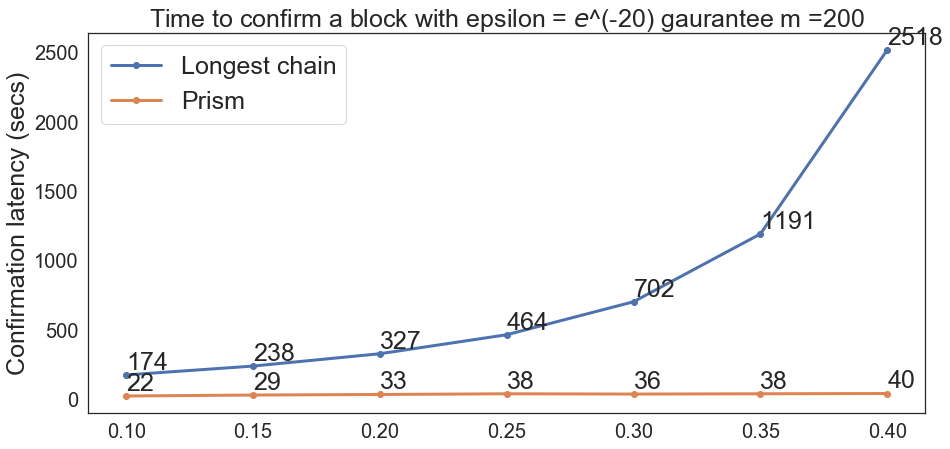

In [198]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans = prism_ans.astype(int)
plt.plot(beta_calc, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.plot(beta_calc, prism_ans, '-o',lw=3, label="Prism")
for i in range(bitcoin_ans.shape[0]):
    ax.annotate(bitcoin_ans[i],xy=(beta_calc[i],bitcoin_ans[i]+40), size=25)
    ax.annotate(prism_ans[i],xy=(beta_calc[i],prism_ans[i]+40), size=25)
plt.ylabel("Confirmation latency (secs)", size=25)
# plt.xlabel("Beta", size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("Time to confirm a block with epsilon = $e$^("+str(-log_epsilon)+") gaurantee m ="+str(m), size=25)
plt.legend(prop={'size': 25})
plt.show()


In [146]:
import sys
k = 10
for i in range(k):
    if (1>2):
        sys.exit()